In [2]:
%config Completer.use_jedi = False

In [3]:
import os, shutil
from glob import glob
from tqdm import tqdm
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset

In [4]:
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(format='%(asctime)s : %(message)s', level=logging.INFO)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")

Current Device: cuda:0


## (1) Directory Settings

In [6]:
basedir = os.getcwd()
datadir = os.path.join(basedir, 'dataset')
print(basedir)

/home/sks/COMPETITION/DACON/computer_vision2


In [7]:
trainset_dir = os.path.join(datadir, 'trainset')

## (2) Image Preprocessing

In [42]:
def img_processing(input_image):
    
    blur = cv2.GaussianBlur(input_image, (3, 3), 0)

    denoised =  cv2.fastNlMeansDenoising(blur, None, 25, 7, 35)
    #denoised = cv2.fastNlMeansDenoising(denoised, None, 10, 7, 21)
    denoised = cv2.fastNlMeansDenoising(denoised, None, 10, 7, 21)
    
    kernel_sharpen = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]]) 
    sharpened = cv2.filter2D(denoised, -1, kernel_sharpen)
    
    logger.info(f'Image processing done.')
    
    return sharpened

In [63]:
np.array(Image.open(sample).convert('RGB')).transpose(2,0,1)[0:1].shape

(1, 256, 256)

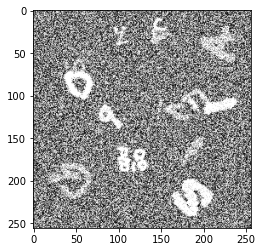

In [43]:
i = 10
sample = glob(os.path.join(trainset_dir, '*.png'))[i]
sample_img = cv2.imread(sample)
#sample_img_base = Image.open(sample)
#sample_img = single_transforms(sample_img_base).squeeze(0).numpy()

plt.imshow(sample_img, cmap='gray')

2021-02-04 19:43:27,441 : Image processing done.


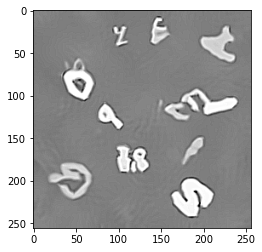

In [38]:
img_processed = img_processing(sample_img)
plt.imshow(img_processed, cmap='gray')

In [39]:
_, thr = cv2.threshold(img_processed, 150, 255, 0)

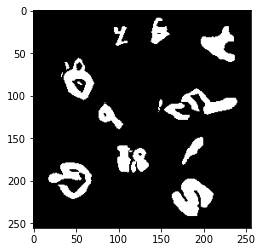

In [40]:
plt.imshow(thr, cmap='gray')

In [365]:
thr.shape

(256, 256, 3)

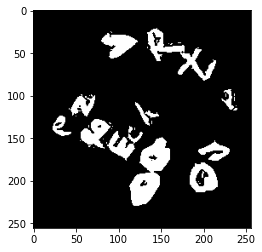

In [347]:
rev = thr+1
plt.imshow(rev, cmap='gray')

In [450]:
rev_3 = np.concatenate((rev, rev, rev), axis)

In [451]:
rev_3.shape

(768, 256)

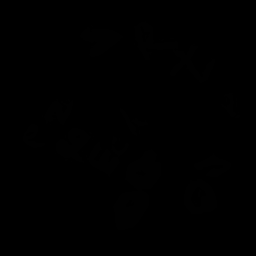

In [449]:
Image.fromarray(rev)

# *Contour

In [86]:
contours, _ = cv2.findContours(thr, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

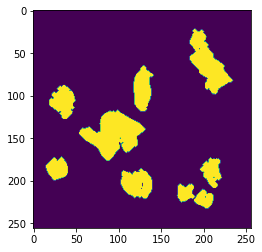

In [87]:
for cnt in contours:
    cnt_draw = cv2.drawContours(thr, [cnt], 0, (255, 0, 0), 3)
    plt.imshow(cnt_draw)

In [974]:
margin = 7
detected = []


bbox_img = img_processed.copy()
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    
    if w*h < 50:
        continue
    
    y_pos, x_pos = y - margin, x-margin
    y_pos = 0 if y_pos < 0 else y_pos
    x_pos = 0 if x_pos < 0 else x_pos
    
    img_roi = img_processed[y_pos:y+h+margin, x_pos:x+w+margin]
    img_roi_resized = cv2.resize(img_roi, (28, 28))
    
    detected.append(img_roi_resized)
    
    cv2.rectangle(bbox_img, (x-margin, y-margin), (x+w+margin, y+h+margin), (0, 255, 0), 2)
    
    #cv2.drawContours(rev, [cnt], 0, (255, 0, 0), 3)

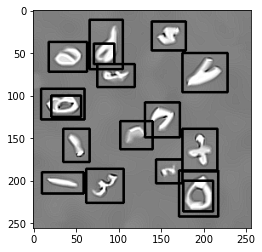

In [975]:
plt.imshow(bbox_img, cmap='gray')

In [976]:
len(detected)

17

## Save cropped images

In [996]:
i = 14

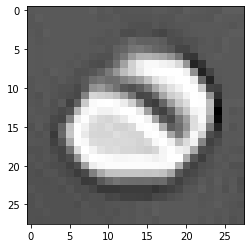

In [997]:
plt.imshow(detected[i], cmap='gray')

In [998]:
single_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
        ])

temp_img = Image.fromarray(detected[i])
to_save = single_transforms(temp_img)

In [999]:
# save
save_image(to_save, './test_sample.png')

### Blur + Otsu

In [434]:
transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
#     transforms.Normalize(
#         [0.5, 0.5, 0.5],
#         [0.5, 0.5, 0.5]
#     )
])

In [435]:
A  = Image.open(sample).convert('RGB')

In [436]:
B = transformer(A)

In [438]:
C = np.array(B.permute(1, 2, 0))

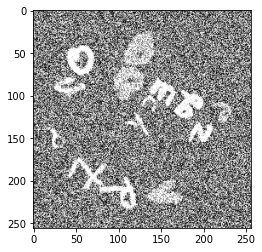

In [439]:
plt.imshow(C, cmap='gray')

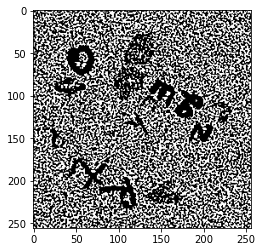

In [444]:
blur = cv2.GaussianBlur(C, (3, 3), 0)
#_, thr = cv2.threshold(blur, 0, 2, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

kernel_sharpen = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]]) 
sharpened = cv2.filter2D(blur, -1, kernel_sharpen)
    
_, thr = cv2.threshold(sharpened, 0.5, 1, 1)
plt.imshow(blur)
plt.imshow(thr)

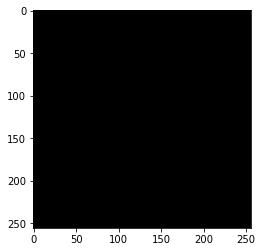

In [394]:
cv2.fastNlMeansDenoising(blur, None, 23, 11, 21)

error: OpenCV(4.5.1) /tmp/pip-req-build-ms668fyv/opencv/modules/photo/src/denoising.cpp:141: error: (-5:Bad argument) Unsupported depth! Only CV_8U is supported for NORM_L2 in function 'fastNlMeansDenoising'


### De-noising

In [232]:
denoised_1 = cv2.fastNlMeansDenoising(blur, None, 25, 7, 49)

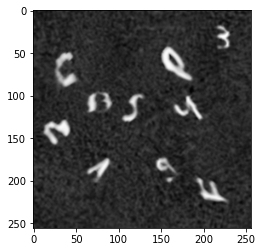

In [233]:
plt.imshow(denoised_1, cmap='gray')

In [234]:
denoised_2 = cv2.fastNlMeansDenoising(denoised_1, None, 10, 7, 21)

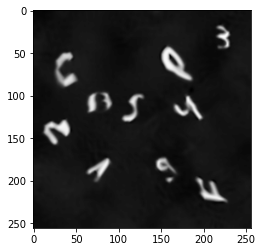

In [235]:
plt.imshow(denoised_2, cmap='gray')

### Erosion

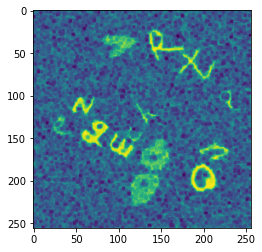

In [251]:
blur = cv2.GaussianBlur(sample_img, (3, 3), 0)
erosion = cv2.erode(blur, kernel, iterations=1)
plt.imshow(erosion)

In [ ]:
denoised =  cv2.fastNlMeansDenoising(blur, None, 15, 7, 49)
denoised = cv2.fastNlMeansDenoising(denoised, None, 13, 7, 21)

In [257]:
kernel = np.ones((2, 2), np.uint8)

erosion = cv2.erode(sample_img, kernel, iterations=1)
dilation = cv2.dilate(sample_img, kernel, iterations=1)

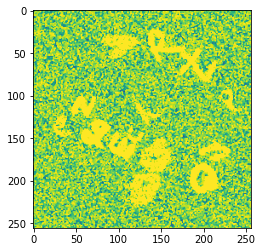

In [258]:
plt.imshow(dilation)

### Opening/Closing

In [259]:
kernel = np.ones((2, 2), np.uint8)
opening = cv2.morphologyEx(dilation, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, kernel)

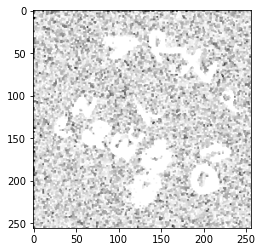

In [262]:
#plt.imshow(opening)
plt.imshow(closing, cmap='gray')

In [239]:
sample_img

array([[ 89, 138, 231, ...,  15, 124, 159],
       [ 78, 157, 153, ..., 228,   4,  23],
       [108, 233, 142, ..., 182, 203, 221],
       ...,
       [ 17, 152,  12, ..., 213, 255,  10],
       [ 85, 124, 135, ...,  63, 156, 132],
       [ 21, 102, 251, ..., 182, 119, 240]], dtype=uint8)

In [39]:
all_images = []
for i in tqdm(range(50000)):
    sample = glob(os.path.join(trainset_dir, '*.png'))[i]
    sample_img = cv2.imread(sample) / 255
    all_images.append(sample_img)

  5%|▍         | 2472/50000 [02:59<57:31, 13.77it/s]  


KeyboardInterrupt: 

In [35]:
reshaped = np.array(all_images)

array([[[0.08627451, 0.08627451, 0.08627451],
        [0.58431373, 0.58431373, 0.58431373],
        [0.15686275, 0.15686275, 0.15686275],
        ...,
        [0.51764706, 0.51764706, 0.51764706],
        [0.29803922, 0.29803922, 0.29803922],
        [0.62745098, 0.62745098, 0.62745098]],

       [[0.38823529, 0.38823529, 0.38823529],
        [0.46666667, 0.46666667, 0.46666667],
        [0.26666667, 0.26666667, 0.26666667],
        ...,
        [0.50980392, 0.50980392, 0.50980392],
        [0.70588235, 0.70588235, 0.70588235],
        [0.6627451 , 0.6627451 , 0.6627451 ]],

       [[0.52941176, 0.52941176, 0.52941176],
        [0.94901961, 0.94901961, 0.94901961],
        [0.97254902, 0.97254902, 0.97254902],
        ...,
        [0.34901961, 0.34901961, 0.34901961],
        [0.93333333, 0.93333333, 0.93333333],
        [0.41960784, 0.41960784, 0.41960784]],

       ...,

       [[0.72156863, 0.72156863, 0.72156863],
        [0.09803922, 0.09803922, 0.09803922],
        [0.1254902 , 0